# Project 1: Classification Algorithms

Compare 6 classification algorithms on 2 datasets using 10-fold cross-validation.


## Setup and Imports


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.base import clone
import warnings
warnings.filterwarnings("ignore")


In [2]:
DATA_FILES = ["project1_dataset1.txt", "project1_dataset2.txt"]
SAVE_RESULTS = True
OUT_DIR = "classification_outputs"
RANDOM_STATE = 42
N_SPLITS = 10


## Data Loading and Preprocessing


In [3]:
def load_dataset(path):
    if not os.path.exists(path):
        print(f"File not found: {path}")
        return None

    try:
        df = pd.read_csv(path, sep=None, engine="python")
        print(f"Loaded: {path} with shape {df.shape}")
        return df
    except Exception as e:
        print(f"Error reading {path}: {e}")
        return None

def prepare_dataframes(df):
    df = df.copy()
    df.dropna(how="all", inplace=True)
    y = df.iloc[:, -1].astype(int)
    X = df.iloc[:, :-1]
    
    numeric_mask = []
    for col in X.columns:
        coerced = pd.to_numeric(X[col], errors="coerce")
        non_null_fraction = coerced.notna().mean()
        if non_null_fraction > 0.9:
            X[col] = coerced
            numeric_mask.append(True)
        else:
            X[col] = X[col].astype(str)
            numeric_mask.append(False)
    
    numeric_mask = np.array(numeric_mask)
    return X, y, numeric_mask

def make_preprocessor(X, numeric_mask):
    numeric_cols = [c for c, m in zip(X.columns, numeric_mask) if m]
    cat_cols = [c for c, m in zip(X.columns, numeric_mask) if not m]

    numeric_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())
    ])
    
    cat_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent", fill_value="missing")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])

    preprocessor = ColumnTransformer(transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", cat_transformer, cat_cols)
    ], remainder="drop")
    
    return preprocessor, numeric_cols, cat_cols


## Baseline Models and Evaluation


In [4]:
def compute_metrics(y_true, y_pred):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0)
    }

baseline_models = {
    "KNN": KNeighborsClassifier(),
    "DecisionTree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "NaiveBayes": GaussianNB(),
    "SVM": SVC(random_state=RANDOM_STATE),
    "AdaBoost": AdaBoostClassifier(random_state=RANDOM_STATE),
    "NeuralNet": MLPClassifier(random_state=RANDOM_STATE, max_iter=1000)
}


In [5]:
def evaluate_models(models, X, y, preprocessor, dataset_name, cv_folds=10):
    print(f"\n=== Evaluating {dataset_name} ===")
    
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_STATE)
    results = {name: [] for name in models.keys()}
    
    for train_idx, test_idx in skf.split(X, y):
        X_train_raw = X.iloc[train_idx]
        X_test_raw = X.iloc[test_idx]
        y_train = y.iloc[train_idx].values
        y_test = y.iloc[test_idx].values
        
        for name, model in models.items():
            clf = clone(model)
            
            try:
                # Check if model is a pipeline (tuned models)
                if hasattr(clf, 'steps') and 'preprocessor' in [step[0] for step in clf.steps]:
                    # Pipeline model - fit directly on raw data
                    clf.fit(X_train_raw, y_train)
                    y_pred = clf.predict(X_test_raw)
                else:
                    # Regular model - need preprocessing
                    preprocessor.fit(X_train_raw)
                    X_train = preprocessor.transform(X_train_raw)
                    X_test = preprocessor.transform(X_test_raw)
                    clf.fit(X_train, y_train)
                    y_pred = clf.predict(X_test)
                
                metrics = compute_metrics(y_test, y_pred)
                results[name].append(metrics)
            except Exception as e:
                print(f"Error evaluating {name}: {e}")
                # Add default metrics if evaluation fails
                results[name].append({
                    "accuracy": 0.0,
                    "precision": 0.0,
                    "recall": 0.0,
                    "f1": 0.0
                })
    
    summary = {}
    for name, metrics_list in results.items():
        summary[name] = {
            "accuracy": (np.mean([m["accuracy"] for m in metrics_list]), 
                        np.std([m["accuracy"] for m in metrics_list])),
            "precision": (np.mean([m["precision"] for m in metrics_list]), 
                         np.std([m["precision"] for m in metrics_list])),
            "recall": (np.mean([m["recall"] for m in metrics_list]), 
                      np.std([m["recall"] for m in metrics_list])),
            "f1": (np.mean([m["f1"] for m in metrics_list]), 
                   np.std([m["f1"] for m in metrics_list]))
        }
    
    return summary, results


## Hyperparameter Tuning


In [6]:
def tune_hyperparameters(model, param_grid, X, y, preprocessor, model_name, cv_folds=3):
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    search = GridSearchCV(pipeline, param_grid, cv=cv_folds, scoring='f1_weighted', n_jobs=1)
    search.fit(X, y)
    
    return search.best_estimator_, search.best_params_

param_grids = {
    'KNN': {
        'classifier__n_neighbors': [3, 5, 7],
        'classifier__weights': ['uniform', 'distance']
    },
    'SVM': {
        'classifier__C': [1, 10, 100],
        'classifier__kernel': ['linear', 'rbf'],
        'classifier__gamma': ['scale', 0.01]
    },
    'DecisionTree': {
        'classifier__max_depth': [None, 10, 15],
        'classifier__min_samples_split': [2, 5]
    },
    'AdaBoost': {
        'classifier__n_estimators': [50, 100],
        'classifier__learning_rate': [1.0, 1.5],
        'classifier__algorithm': ['SAMME']
    },
    'NeuralNet': {
        'classifier__hidden_layer_sizes': [(50,), (100,)],
        'classifier__alpha': [0.001, 0.01]
    }
}


## Main Experiment


In [7]:
datasets = {}
for fpath in DATA_FILES:
    if os.path.exists(fpath):
        df = load_dataset(fpath)
        X, y, numeric_mask = prepare_dataframes(df)
        preprocessor, numeric_cols, cat_cols = make_preprocessor(X, numeric_mask)
        
        datasets[fpath] = {
            'X': X, 'y': y, 'preprocessor': preprocessor,
            'numeric_cols': numeric_cols, 'cat_cols': cat_cols
        }


Loaded: project1_dataset1.txt with shape (568, 31)
Loaded: project1_dataset2.txt with shape (461, 10)


In [8]:
baseline_results = {}
for dataset_name, data in datasets.items():
    baseline_results[dataset_name], _ = evaluate_models(
        baseline_models, data['X'], data['y'], 
        data['preprocessor'], f"Baseline - {dataset_name}"
    )



=== Evaluating Baseline - project1_dataset1.txt ===

=== Evaluating Baseline - project1_dataset2.txt ===


In [9]:
tuned_models = {}
tuning_results = {}

for dataset_name, data in datasets.items():
    tuned_models[dataset_name] = {}
    tuning_results[dataset_name] = {}
    
    for model_name, param_grid in param_grids.items():
        if model_name in baseline_models:
            try:
                best_model, best_params = tune_hyperparameters(
                    baseline_models[model_name], param_grid,
                    data['X'], data['y'], data['preprocessor'], model_name
                )
                tuned_models[dataset_name][model_name] = best_model
                tuning_results[dataset_name][model_name] = best_params
            except Exception as e:
                tuned_models[dataset_name][model_name] = baseline_models[model_name]
                tuning_results[dataset_name][model_name] = {}
    
    tuned_models[dataset_name]['NaiveBayes'] = baseline_models['NaiveBayes']


In [10]:
tuned_results = {}
for dataset_name, models in tuned_models.items():
    tuned_results[dataset_name], _ = evaluate_models(
        models, datasets[dataset_name]['X'], datasets[dataset_name]['y'], 
        datasets[dataset_name]['preprocessor'], f"Tuned - {dataset_name}"
    )



=== Evaluating Tuned - project1_dataset1.txt ===


KeyboardInterrupt: 

## Results Analysis


In [ ]:
def display_results(results, dataset_name, round_name):
    print(f"\n{dataset_name} - {round_name} Results (Mean ± Std)")
    print("=" * 80)
    print(f"{'Algorithm':<12} {'Accuracy':<15} {'Precision':<15} {'Recall':<15} {'F1-Score':<15}")
    print("-" * 80)
    
    sorted_results = sorted(results.items(), key=lambda x: x[1]['f1'][0], reverse=True)
    
    for name, metrics in sorted_results:
        acc_mean, acc_std = metrics['accuracy']
        prec_mean, prec_std = metrics['precision']
        rec_mean, rec_std = metrics['recall']
        f1_mean, f1_std = metrics['f1']
        
        print(f"{name:<12} {acc_mean:.4f}±{acc_std:.4f}   {prec_mean:.4f}±{prec_std:.4f}   {rec_mean:.4f}±{rec_std:.4f}   {f1_mean:.4f}±{f1_std:.4f}")

for dataset_name, results in baseline_results.items():
    display_results(results, os.path.basename(dataset_name), "Baseline")

for dataset_name, results in tuned_results.items():
    display_results(results, os.path.basename(dataset_name), "Tuned")



project1_dataset1.txt - Baseline Results (Mean ± Std)
Algorithm    Accuracy        Precision       Recall          F1-Score       
--------------------------------------------------------------------------------
NeuralNet    0.9736±0.0117   0.9772±0.0300   0.9526±0.0301   0.9641±0.0161
SVM          0.9719±0.0211   0.9727±0.0404   0.9528±0.0295   0.9621±0.0275
KNN          0.9684±0.0172   0.9855±0.0222   0.9290±0.0381   0.9559±0.0240
AdaBoost     0.9543±0.0225   0.9569±0.0328   0.9195±0.0477   0.9369±0.0314
NaiveBayes   0.9279±0.0362   0.9156±0.0774   0.8959±0.0508   0.9032±0.0456
DecisionTree 0.9245±0.0359   0.8988±0.0592   0.9004±0.0582   0.8984±0.0486

project1_dataset2.txt - Baseline Results (Mean ± Std)
Algorithm    Accuracy        Precision       Recall          F1-Score       
--------------------------------------------------------------------------------
NaiveBayes   0.7027±0.0672   0.5673±0.0828   0.6375±0.1179   0.5965±0.0895
NeuralNet    0.7134±0.0628   0.6151±0.1234   0.48

In [ ]:


for dataset_name in baseline_results.keys():
    print(f"\n{os.path.basename(dataset_name)} - Performance Improvement Analysis:")
    print("-" * 80)
    print(f"{'Algorithm':<12} {'Baseline F1':<15} {'Tuned F1':<15} {'Improvement':<15}")
    print("-" * 80)
    
    for alg in baseline_results[dataset_name].keys():
        baseline_f1 = baseline_results[dataset_name][alg]['f1'][0]
        tuned_f1 = tuned_results[dataset_name][alg]['f1'][0]
        improvement = tuned_f1 - baseline_f1
        
        print(f"{alg:<12} {baseline_f1:.4f}±{baseline_results[dataset_name][alg]['f1'][1]:.4f}   {tuned_f1:.4f}±{tuned_results[dataset_name][alg]['f1'][1]:.4f}   {improvement:+.4f}")



SENSITIVITY ANALYSIS: BASELINE vs TUNED PERFORMANCE

project1_dataset1.txt - Performance Improvement Analysis:
--------------------------------------------------------------------------------
Algorithm    Baseline F1     Tuned F1        Improvement    
--------------------------------------------------------------------------------
KNN          0.9559±0.0240   0.9560±0.0241   +0.0001
DecisionTree 0.8984±0.0486   0.8984±0.0486   +0.0000
NaiveBayes   0.9032±0.0456   0.9032±0.0456   +0.0000
SVM          0.9621±0.0275   0.9734±0.0170   +0.0113
AdaBoost     0.9369±0.0314   0.9709±0.0183   +0.0340
NeuralNet    0.9641±0.0161   0.9641±0.0161   +0.0000

project1_dataset2.txt - Performance Improvement Analysis:
--------------------------------------------------------------------------------
Algorithm    Baseline F1     Tuned F1        Improvement    
--------------------------------------------------------------------------------
KNN          0.4576±0.1113   0.4368±0.1345   -0.0207
DecisionTree

Results Visualization and Export


Creating 4 separate visualizations...


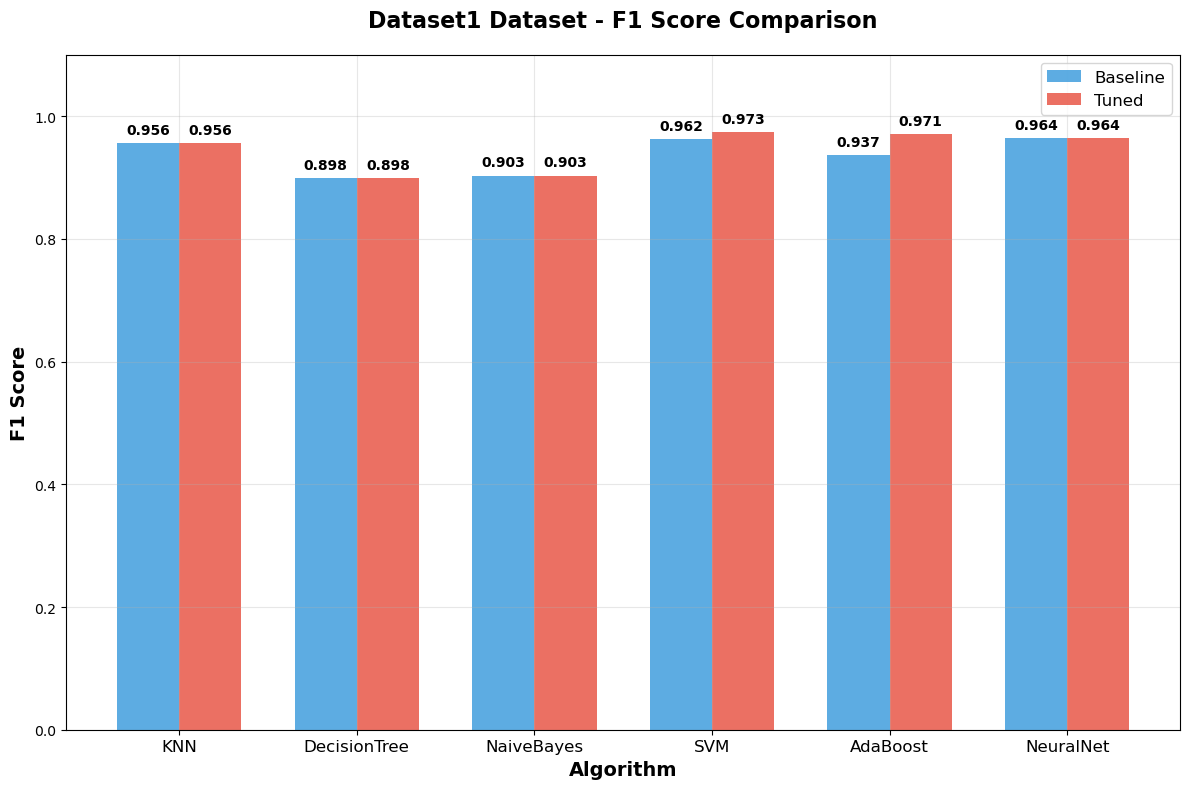

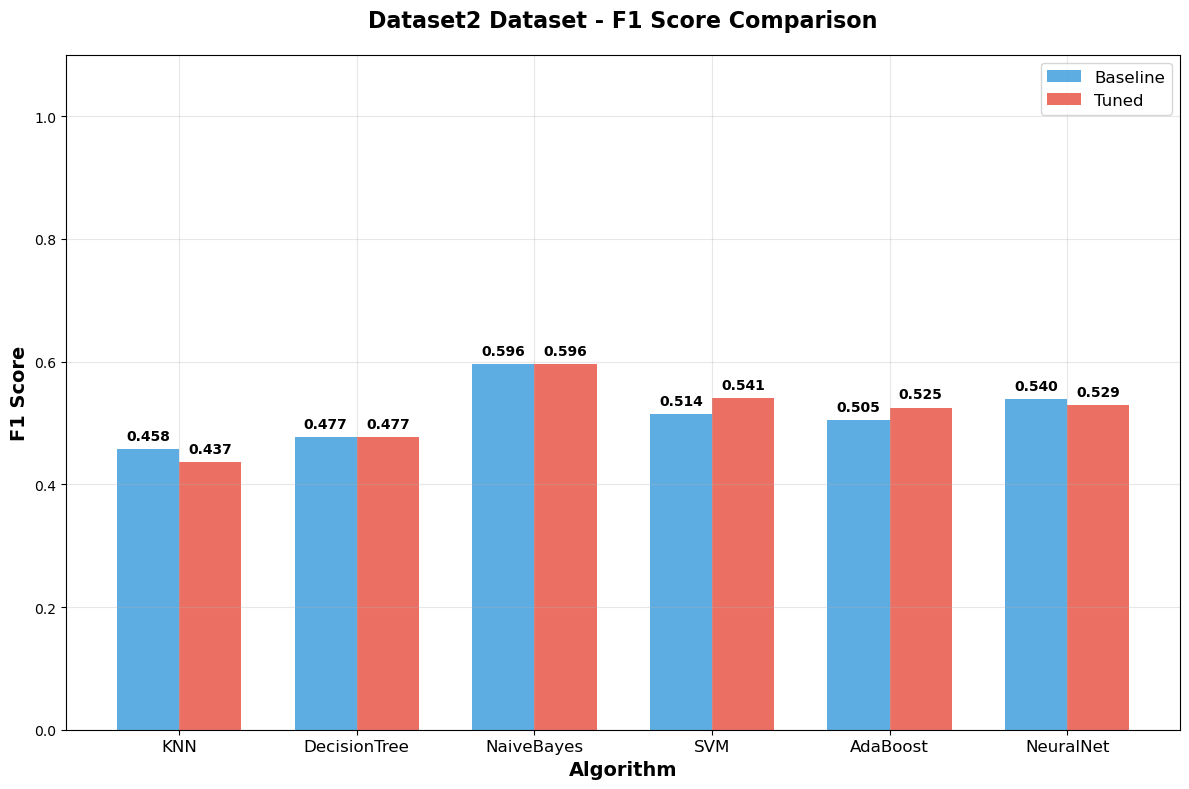

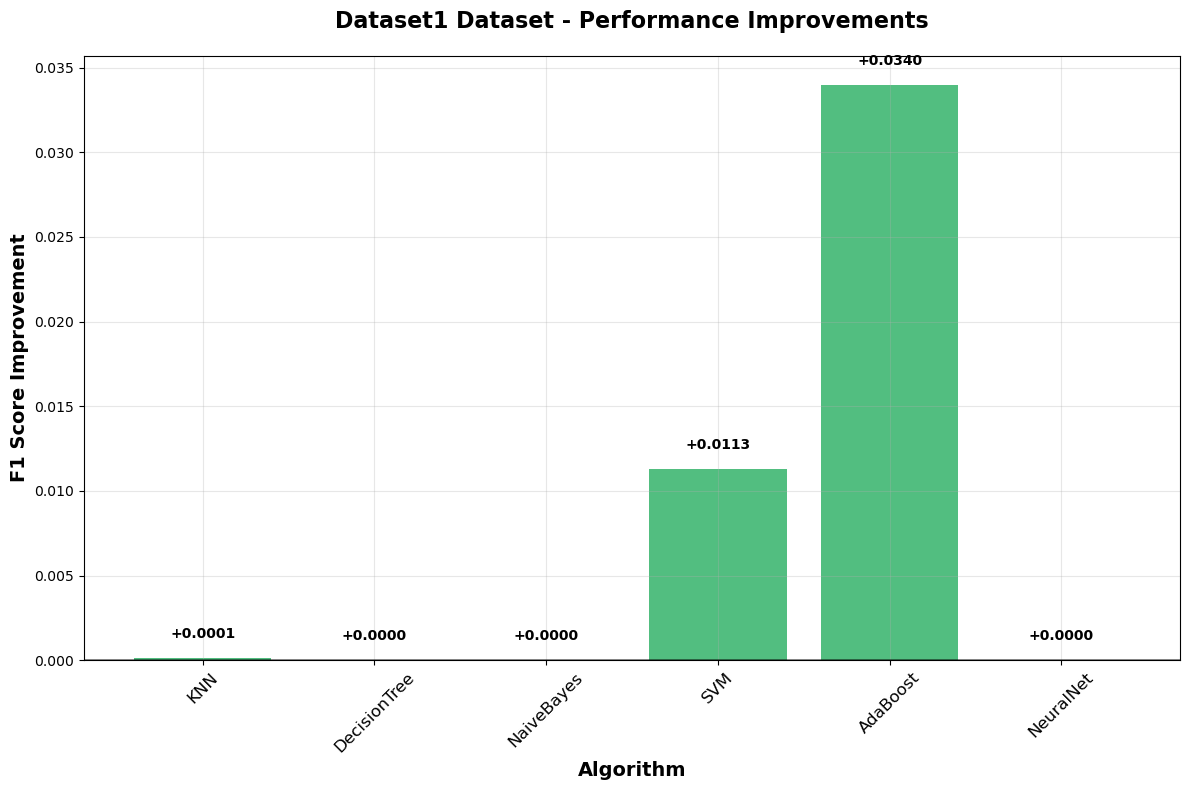

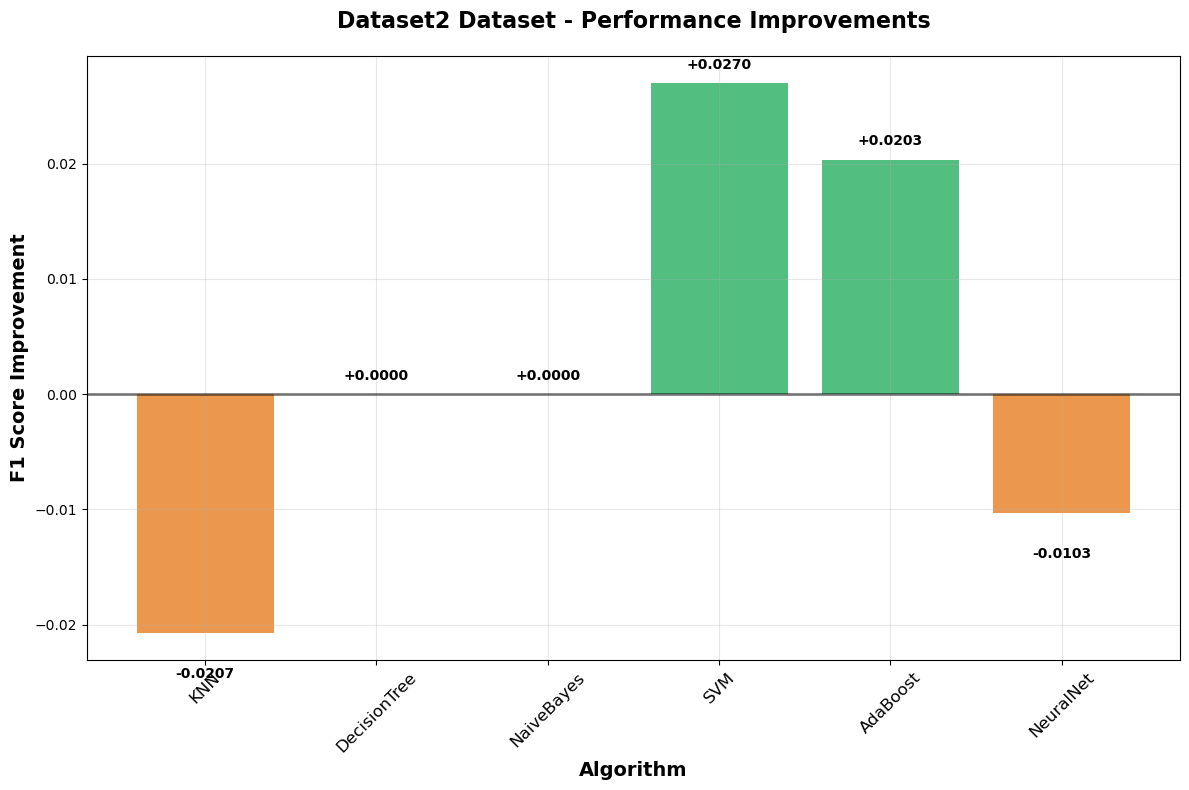

In [ ]:
# Get dataset names and clean them
dataset_names = list(baseline_results.keys())
d1_name = os.path.basename(dataset_names[0]).replace('.txt', '').replace('project1_', '').title()
d2_name = os.path.basename(dataset_names[1]).replace('.txt', '').replace('project1_', '').title()

algorithms = list(baseline_results[dataset_names[0]].keys())

# Simple color scheme
colors = {
    'baseline': '#3498db',    # Blue
    'tuned': '#e74c3c',       # Red
    'improvement': '#27ae60', # Green
    'decline': '#e67e22'      # Orange
}

print("Creating 4 separate visualizations...")

# =============================================================================
# GRAPH 1: Dataset 1 - F1 Score Comparison
# =============================================================================
plt.figure(figsize=(12, 8))

baseline_f1_1 = [baseline_results[dataset_names[0]][alg]['f1'][0] for alg in algorithms]
tuned_f1_1 = [tuned_results[dataset_names[0]][alg]['f1'][0] for alg in algorithms]

x = np.arange(len(algorithms))
width = 0.35

bars1 = plt.bar(x - width/2, baseline_f1_1, width, label='Baseline', 
                color=colors['baseline'], alpha=0.8)
bars2 = plt.bar(x + width/2, tuned_f1_1, width, label='Tuned', 
                color=colors['tuned'], alpha=0.8)

# Add value labels
for bar1, bar2 in zip(bars1, bars2):
    height1 = bar1.get_height()
    height2 = bar2.get_height()
    plt.text(bar1.get_x() + bar1.get_width()/2., height1 + 0.01,
             f'{height1:.3f}', ha='center', va='bottom', fontweight='bold')
    plt.text(bar2.get_x() + bar2.get_width()/2., height2 + 0.01,
             f'{height2:.3f}', ha='center', va='bottom', fontweight='bold')

plt.title(f'{d1_name} Dataset - F1 Score Comparison', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('F1 Score', fontsize=14, fontweight='bold')
plt.xlabel('Algorithm', fontsize=14, fontweight='bold')
plt.xticks(x, algorithms, fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.ylim(0, 1.1)

plt.tight_layout()
plt.savefig('graph1_dataset1_f1_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# =============================================================================
# GRAPH 2: Dataset 2 - F1 Score Comparison
# =============================================================================
plt.figure(figsize=(12, 8))

baseline_f1_2 = [baseline_results[dataset_names[1]][alg]['f1'][0] for alg in algorithms]
tuned_f1_2 = [tuned_results[dataset_names[1]][alg]['f1'][0] for alg in algorithms]

bars3 = plt.bar(x - width/2, baseline_f1_2, width, label='Baseline', 
                color=colors['baseline'], alpha=0.8)
bars4 = plt.bar(x + width/2, tuned_f1_2, width, label='Tuned', 
                color=colors['tuned'], alpha=0.8)

# Add value labels
for bar3, bar4 in zip(bars3, bars4):
    height3 = bar3.get_height()
    height4 = bar4.get_height()
    plt.text(bar3.get_x() + bar3.get_width()/2., height3 + 0.01,
             f'{height3:.3f}', ha='center', va='bottom', fontweight='bold')
    plt.text(bar4.get_x() + bar4.get_width()/2., height4 + 0.01,
             f'{height4:.3f}', ha='center', va='bottom', fontweight='bold')

plt.title(f'{d2_name} Dataset - F1 Score Comparison', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('F1 Score', fontsize=14, fontweight='bold')
plt.xlabel('Algorithm', fontsize=14, fontweight='bold')
plt.xticks(x, algorithms, fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.ylim(0, 1.1)

plt.tight_layout()
plt.savefig('graph2_dataset2_f1_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# =============================================================================
# GRAPH 3: Dataset 1 - Performance Improvements
# =============================================================================
plt.figure(figsize=(12, 8))

improvements_1 = [tuned_f1_1[i] - baseline_f1_1[i] for i in range(len(algorithms))]
colors_1 = [colors['improvement'] if imp > 0 else colors['decline'] for imp in improvements_1]

bars5 = plt.bar(algorithms, improvements_1, color=colors_1, alpha=0.8)

# Add value labels
for bar, imp in zip(bars5, improvements_1):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + (0.001 if height >= 0 else -0.003),
             f'{imp:+.4f}', ha='center', va='bottom' if height >= 0 else 'top', 
             fontweight='bold')

plt.title(f'{d1_name} Dataset - Performance Improvements', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('F1 Score Improvement', fontsize=14, fontweight='bold')
plt.xlabel('Algorithm', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=2)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('graph3_dataset1_improvements.png', dpi=300, bbox_inches='tight')
plt.show()

# =============================================================================
# GRAPH 4: Dataset 2 - Performance Improvements
# =============================================================================
plt.figure(figsize=(12, 8))

improvements_2 = [tuned_f1_2[i] - baseline_f1_2[i] for i in range(len(algorithms))]
colors_2 = [colors['improvement'] if imp > 0 else colors['decline'] for imp in improvements_2]

bars6 = plt.bar(algorithms, improvements_2, color=colors_2, alpha=0.8)

# Add value labels
for bar, imp in zip(bars6, improvements_2):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + (0.001 if height >= 0 else -0.003),
             f'{imp:+.4f}', ha='center', va='bottom' if height >= 0 else 'top', 
             fontweight='bold')

plt.title(f'{d2_name} Dataset - Performance Improvements', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('F1 Score Improvement', fontsize=14, fontweight='bold')
plt.xlabel('Algorithm', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=2)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('graph4_dataset2_improvements.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# Evaluate tuned models
tuned_results = {}
for dataset_name, models in tuned_models.items():
    tuned_results[dataset_name], _ = evaluate_models(
        models, datasets[dataset_name]['X'], datasets[dataset_name]['y'], 
        datasets[dataset_name]['preprocessor'], f"Tuned - {dataset_name}"
    )



=== Evaluating Tuned - project1_dataset1.txt ===

=== Evaluating Tuned - project1_dataset2.txt ===


In [ ]:
# Create formatted results table
def create_results_table(dataset_name, baseline_data, tuned_data):
    table_data = []
    for alg in algorithms:
        baseline_f1 = baseline_data[alg]['f1'][0]
        tuned_f1 = tuned_data[alg]['f1'][0]
        improvement = tuned_f1 - baseline_f1
        
        table_data.append([
            alg,
            f"{baseline_f1:.4f}",
            f"{tuned_f1:.4f}",
            f"{improvement:+.4f}"
        ])
    
    headers = ["Algorithm", "Baseline F1", "Tuned F1", "Improvement"]
    return tabulate(table_data, headers=headers, tablefmt="grid", stralign="center")


for i, dataset_name in enumerate(dataset_names):
    print(f"\n{os.path.basename(dataset_name)} Results:")
    print(create_results_table(dataset_name, baseline_results[dataset_name], tuned_results[dataset_name]))

# Save to file
with open('classification_results_table.txt', 'w') as f:
    f.write("CLASSIFICATION ALGORITHMS COMPARISON RESULTS\n")
    f.write("="*50 + "\n\n")
    
    for dataset_name in dataset_names:
        f.write(f"{os.path.basename(dataset_name)} Results:\n")
        f.write(create_results_table(dataset_name, baseline_results[dataset_name], tuned_results[dataset_name]))
        f.write("\n\n")
    
    f.write("Generated: " + pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S"))

print(f"\nResults table saved to: classification_results_table.txt")
print(f"Visualization saved to: classification_results_visualization.png")



project1_dataset1.txt Results:
+--------------+---------------+------------+---------------+
|  Algorithm   |   Baseline F1 |   Tuned F1 |   Improvement |
+==============+===============+============+===============+
|     KNN      |        0.9559 |     0.956  |        0.0001 |
+--------------+---------------+------------+---------------+
| DecisionTree |        0.8984 |     0.8984 |        0      |
+--------------+---------------+------------+---------------+
|  NaiveBayes  |        0.9032 |     0.9032 |        0      |
+--------------+---------------+------------+---------------+
|     SVM      |        0.9621 |     0.9734 |        0.0113 |
+--------------+---------------+------------+---------------+
|   AdaBoost   |        0.9369 |     0.9709 |        0.034  |
+--------------+---------------+------------+---------------+
|  NeuralNet   |        0.9641 |     0.9641 |        0      |
+--------------+---------------+------------+---------------+

project1_dataset2.txt Results:
+-----